In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
import warnings
from pandas.tseries.offsets import BDay
from scipy.optimize import minimize
from tqdm import tqdm
import math
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import pmdarima

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.4f}'.format

In [2]:
ticker = "TSLA"
df = yf.download(tickers=[ticker],period="90d",interval="1d",auto_adjust=True).reset_index()

[*********************100%***********************]  1 of 1 completed


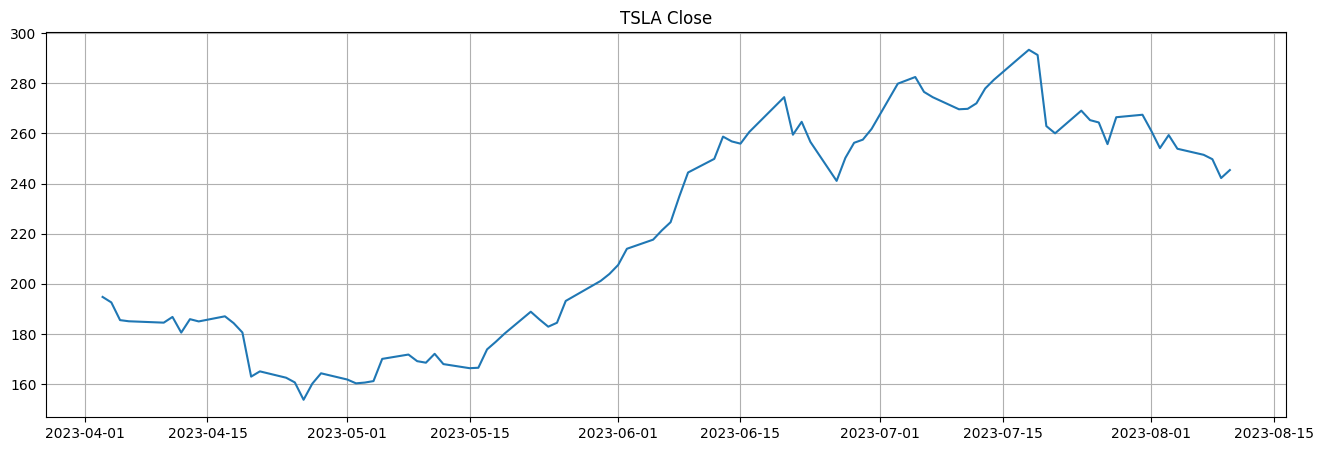

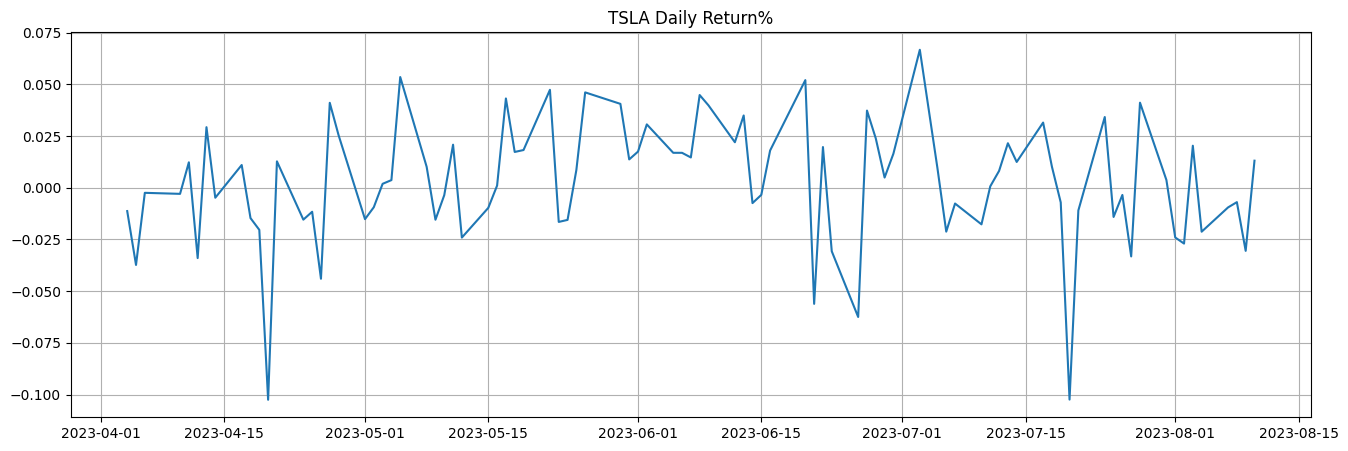

In [3]:
df["Return"] = df["Close"].pct_change()
df["Return_Log"] = np.log(df.Close) - np.log(df.Close.shift(1))

plt.figure(figsize=(16,5))
plt.title("{} Close".format(ticker))
plt.plot(df["Date"], df["Close"])
plt.grid()
plt.show()

plt.figure(figsize=(16,5))
plt.title("{} Daily Return%".format(ticker))
plt.plot(df["Date"], df["Return_Log"])
plt.grid()
plt.show()

# Stationary Test
- Conduct augmented dickey-fuller test to if the time-series is stationary or not
- we should only conduct the analysis on stationary time series

In [26]:
closes = df["Close"].values
returns = df["Return_Log"].values
returns = np.array(list(filter(lambda x: not math.isnan(x), returns)))

close_pvalue = adfuller(closes)[1]
return_pvalue = adfuller(returns)[1]

print("Pvalue of close price: {:.5f}%".format(close_pvalue*100))
print("Pvalue of returns: {:.5f}%".format(return_pvalue*100))

if return_pvalue < 0.05:
    print("stock's return are stationary")
else:
    print("stock's return are non-stationary, should not apply below time-series analysis")

Pvalue of close price: 83.54756%
Pvalue of returns: 0.00000%
stock's return are stationary


# ACF and PACF plots
- ACF to find the MA orders
- PACF to find the AR orders
- Typically the orders seems to be significant at 5th, is it becuase of 1-week?

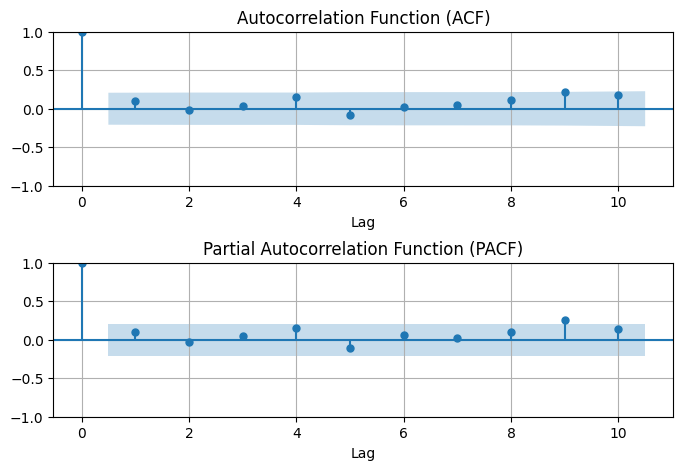

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))
plt.subplots_adjust(hspace=0.5)

max_ar = 10
max_ma = 10

plot_acf(returns, lags=max_ma, ax=ax1)
plot_pacf(returns, lags=max_ar, ax=ax2)
ax1.set_title('Autocorrelation Function (ACF)')
ax1.set_xlabel('Lag')
ax1.grid()
ax2.set_title('Partial Autocorrelation Function (PACF)')
ax2.set_xlabel('Lag')
ax2.grid()
plt.show()

# Try fitting a ARMA models
- $AIC = 2k - 2l$
- $BIC = kln(n) - 2l$
- where
    - k = number of parameters
    - n = samples used for fitting
    - l = log likelihodd function

In [28]:
#model = pmdarima.auto_arima(returns,stepwise=False,seasonal=False)
model = pmdarima.ARIMA((5,0,5)).fit(returns)
orders = model.order
print("best arma orders: AR:{}, D:{}, MA:{}".format(*orders))

best arma orders: AR:5, D:0, MA:5


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   89
Model:               SARIMAX(5, 0, 5)   Log Likelihood                 190.486
Date:                Fri, 11 Aug 2023   AIC                           -356.972
Time:                        00:11:48   BIC                           -327.109
Sample:                             0   HQIC                          -344.935
                                 - 89                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.004      0.222      0.824      -0.007       0.009
ar.L1          0.0172      0.461      0.037      0.970      -0.886       0.921
ar.L2          0.0896      0.482      0.186      0.8

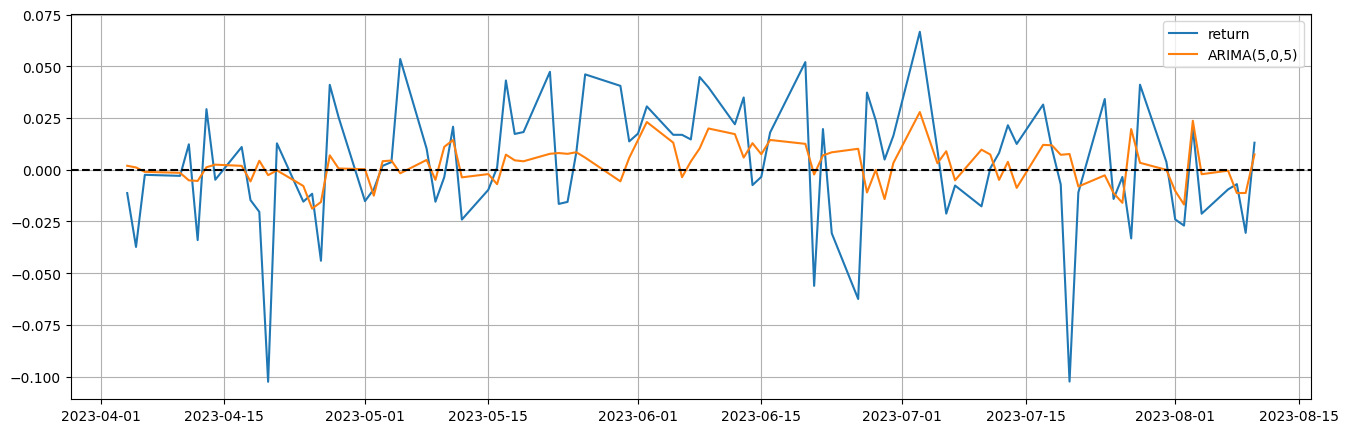

In [29]:
dates = df["Date"].values[1:]
print(model.summary())

plt.figure(figsize=(16,5))
plt.plot(dates, returns, label="return")
plt.plot(dates, model.predict_in_sample(), label="ARIMA({},{},{})".format(*orders))

plt.axhline(0,color="black",linestyle="--")
plt.grid()
plt.legend()
plt.show()

## Example to fit the data (using ARMA to generate the samples)

In [30]:
# from statsmodels.tsa.arima_process import arma_generate_sample
# arparams = np.array([0.75, -0.25])
# maparams = np.array([0.65, 0.35])
# arparams = np.r_[1, -arparams]
# maparams = np.r_[1, maparams]
# nobs = 250
# y = arma_generate_sample(arparams, maparams, nobs)
# model = pmdarima.auto_arima(y)
# print(model.summary())
# plt.figure(figsize=(7,3))
# plt.plot(y, label="actual")
# plt.plot(model.predict_in_sample(), label="fitted")
# plt.legend()
# plt.show()

# Try fitting a GARCH(1,1) model to predict volatility
- Plot ACF and PACF using squared returns (squared returns is something for GARCH orders)
- try to compare the fitted volatility vs rolling standard derivation of returns

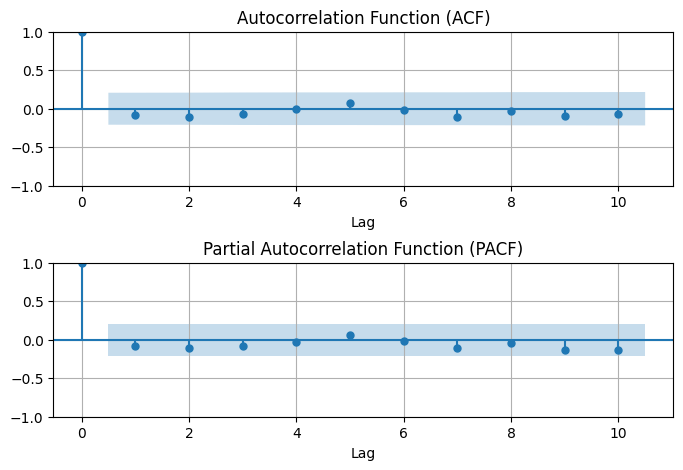

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))
plt.subplots_adjust(hspace=0.5)
max_ar = 10
max_ma = 10
plot_acf(returns**2, lags=max_ma, ax=ax1)
plot_pacf(returns**2, lags=max_ar, ax=ax2)
ax1.set_title('Autocorrelation Function (ACF)')
ax1.set_xlabel('Lag')
ax1.grid()
ax2.set_title('Partial Autocorrelation Function (PACF)')
ax2.set_xlabel('Lag')
ax2.grid()
plt.show()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 29.483107315746146
Iteration:      2,   Func. Count:     12,   Neg. LLF: -185.73951161498306
Iteration:      3,   Func. Count:     16,   Neg. LLF: -185.74161093531083
Iteration:      4,   Func. Count:     20,   Neg. LLF: -185.7547385681221
Iteration:      5,   Func. Count:     24,   Neg. LLF: -183.51385205720084
Iteration:      6,   Func. Count:     29,   Neg. LLF: -184.30621102329815
Iteration:      7,   Func. Count:     34,   Neg. LLF: -185.0024807234259
Iteration:      8,   Func. Count:     39,   Neg. LLF: 70291.72866958819
Iteration:      9,   Func. Count:     46,   Neg. LLF: -185.5998618573277
Iteration:     10,   Func. Count:     51,   Neg. LLF: -185.73329450299346
Iteration:     11,   Func. Count:     56,   Neg. LLF: -185.77206664337774
Iteration:     12,   Func. Count:     61,   Neg. LLF: -185.7774739721551
Iteration:     13,   Func. Count:     65,   Neg. LLF: -185.77754980732857
Iteration:     14,   Func. Count:     68,   N

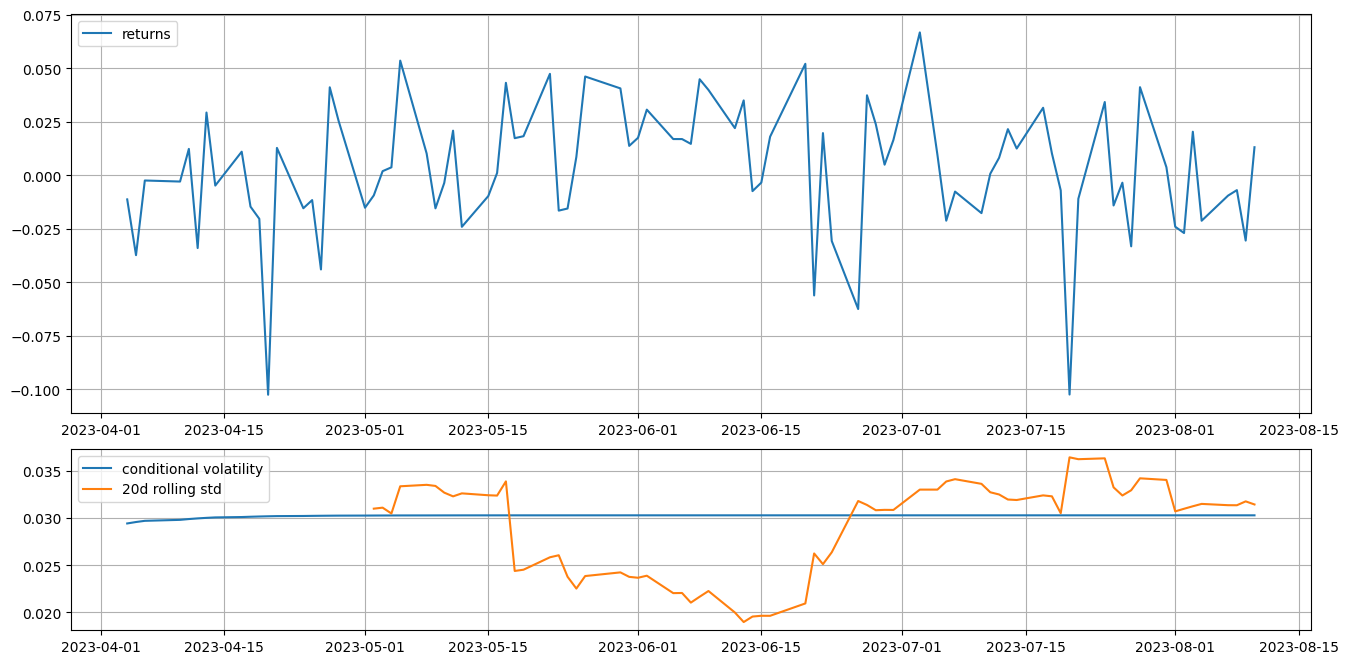

In [37]:
#am = arch_model(returns)
#am = arch_model(returns)
am = arch_model(returns, p=1, q=1, mean='Zero')
res = am.fit()
print(res.summary())

dates = df["Date"].values[1:]
windows = 20
df["Return_Log_Std"] = df['Return_Log'].rolling(windows).std()

fig = plt.figure(figsize=(16,8))
spec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
ax = fig.add_subplot(spec[:2,0])
ax.plot(dates, returns, label="returns")
ax.grid()
ax.legend(loc="upper left")
ax = fig.add_subplot(spec[2,0])
ax.plot(dates, res.conditional_volatility, label="conditional volatility")
ax.plot(df["Date"], df["Return_Log_Std"], label="{}d rolling std".format(windows))
ax.legend(loc="upper left")
ax.grid()
plt.show()

# Combining both ARCH and GARCH models to predict stock prices in next few days
- ARIMA(5,0,5) model to predict conditional mean given returns
- GARCH(1,1) model to predict conditional variance given returns
- Given both mean and variance, we can use it to predict the stock price by $mean \pm \sqrt{var}$

In [41]:
# out samples days
os_days = 5
forecast_days = 5

In [42]:
train_returns = returns[:-os_days]
train_dates = dates[:-os_days]

# out sample dates and actual forecast dates
forecast_dates = list(dates[-os_days:]) + [dates[-1] + BDay(i+1) for i in range(forecast_days)]

In [43]:
# arima_model
arima_model = pmdarima.ARIMA((5,0,5)).fit(train_returns)

# garch(1,1) model
garch_model = arch_model(train_returns, p=1, q=1, mean='zero').fit(disp=False)

In [44]:
predicted_mu_in_sample = arima_model.predict_in_sample()
predicted_vol_in_sample = garch_model.conditional_volatility

predicted_mu = arima_model.predict(n_periods=os_days+forecast_days)

garch_forecast = garch_model.forecast(horizon=os_days+forecast_days)
predicted_var = garch_forecast.residual_variance.iloc[-1].values

in_samples_predict_up = predicted_mu_in_sample + predicted_vol_in_sample
in_samples_predict_down = predicted_mu_in_sample - predicted_vol_in_sample
out_samples_predict_up = predicted_mu + np.sqrt(predicted_var)
out_samples_predict_down = predicted_mu - np.sqrt(predicted_var)

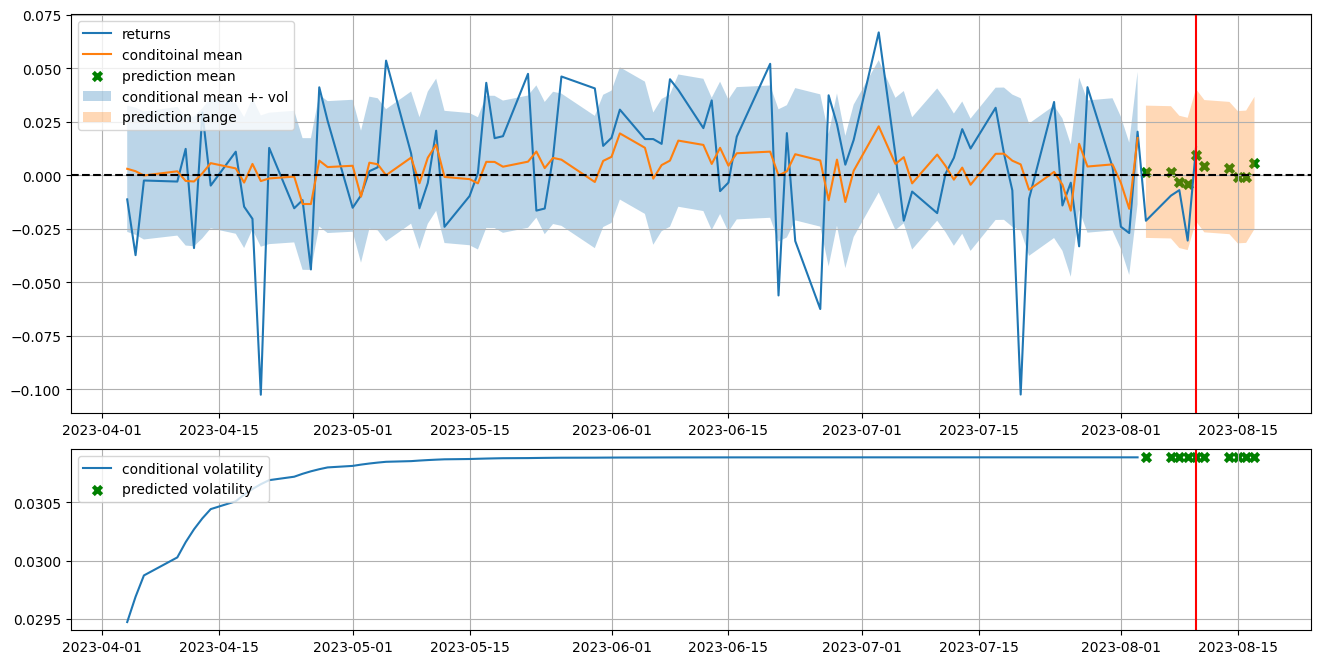

in sample test


,Date,actual_return (%),predicted_return (%),predicted_vol (%),predicted_range_upper (%),predicted_range_lower (%)
0,2023-08-04,-2.1280,0.1591,3.0887,-2.9296,3.2479
1,2023-08-07,-0.9539,0.1329,3.0887,-2.9559,3.2216
2,2023-08-08,-0.6984,-0.3131,3.0887,-3.4018,2.7756
3,2023-08-09,-3.0538,-0.4089,3.0887,-3.4976,2.6799
4,2023-08-10,1.3060,0.9316,3.0887,-2.1571,4.0203


In [45]:
fig = plt.figure(figsize=(16,8))
spec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)

ax = fig.add_subplot(spec[:2,0])
ax.plot(dates,returns, label="returns")
ax.plot(train_dates,predicted_mu_in_sample,label="conditoinal mean")
ax.scatter(forecast_dates,predicted_mu,label="prediction mean", marker="x", color="g", linewidth=3)

ax.axvline(dates[-1],color="red")
ax.axhline(0,color="black",linestyle="--")
ax.fill_between(train_dates,in_samples_predict_up, in_samples_predict_down, alpha=0.3,label="conditional mean +- vol")
ax.fill_between(forecast_dates,out_samples_predict_up, out_samples_predict_down,alpha=0.3, label="prediction range")

ax.legend(loc="upper left")
ax.grid()
ax = fig.add_subplot(spec[2,0])
ax.plot(train_dates, garch_model.conditional_volatility, label="conditional volatility")
ax.scatter(forecast_dates, np.sqrt(predicted_var), label="predicted volatility", marker="x", color="g", linewidth=3)
ax.axvline(dates[-1],color="red")
ax.legend(loc="upper left")
ax.grid()
plt.show()

print("in sample test")
df_temp = pd.DataFrame({
    "Date": dates[-os_days:], 
    "actual_return (%)": returns[-os_days:]*100,
    "predicted_return (%)": predicted_mu[:os_days]*100,
    "predicted_vol (%)": np.sqrt(predicted_var[:os_days])*100,
    "predicted_range_upper (%)": predicted_mu[:os_days]*100 - np.sqrt(predicted_var[:os_days])*100,
    "predicted_range_lower (%)": predicted_mu[:os_days]*100 + np.sqrt(predicted_var[:os_days])*100,    
})
df_temp

# Simulate by running the model with rolling windows

In [53]:
train_dates = 20
returns = np.log(df["Close"]).diff().values
dates = df["Date"].values

In [54]:
d_v = []
r_v = []
mu_v = []
vol_v = []

with tqdm(total=len(dates)-train_dates) as pbar:
    for i in range(10,len(dates)):
        d = dates[i]        
        r = returns[i-10:i]
        r = r[~np.isnan(r)]        

        arima_model = pmdarima.ARIMA((5,0,5)).fit(r)
        garch_model = arch_model(r, p=1, q=1, mean='zero').fit(disp=False)    
        
        mu = arima_model.predict(n_periods=1)[0]
        vol = np.sqrt(garch_model.forecast(horizon=1).residual_variance.iloc[-1].values[0])    
        
        d_v.append(d)
        r_v.append(returns[i])
        mu_v.append(mu)
        vol_v.append(vol)
        pbar.update(1) 

80it [00:07, 10.90it/s]                                                                                                                                                                 


In [55]:
df_predict = pd.DataFrame({
    "Date": d_v,
    "Return_actual": r_v,
    "Return_predict": mu_v,
    "Volatility_predict": vol_v        
})   
df_predict = pd.merge(df, df_predict, on=["Date"], how="left", validate="1:1")
df_predict["Return_predict_upper"] = df_predict["Return_predict"] + df_predict["Volatility_predict"]
df_predict["Return_predict_lower"] = df_predict["Return_predict"] - df_predict["Volatility_predict"]
df_predict["is_sim"] = ~df_predict["Return_predict"].isnull()

df_predict["accuracy_dir"] = np.sign(df_predict["Return_actual"])+np.sign(df_predict["Return_predict"])!=0
df_predict["accuracy_inrange"] = df_predict.apply(
    lambda x: 
        x["Return_actual"] >= x["Return_predict_lower"] and 
        x["Return_actual"] <= x["Return_predict_upper"], axis=1)

print("Accuracy (directional): {:.1f}%".format(df_predict["accuracy_dir"].sum()/df_predict["is_sim"].sum()*100))
print("Accuracy (in range)   : {:.1f}%".format(df_predict["accuracy_inrange"].sum()/df_predict["is_sim"].sum()*100))

df_predict.tail(5)

Accuracy (directional): 65.0%
Accuracy (in range)   : 46.2%


,Date,Open,High,Low,Close,Volume,Return,Return_Log,Return_Log_Std,Return_actual,Return_predict,Volatility_predict,Return_predict_upper,Return_predict_lower,is_sim,accuracy_dir,accuracy_inrange
85,2023-08-04,260.9700,264.7700,253.1100,253.8600,99242600,-0.0211,-0.0213,0.0315,-0.0213,0.0328,0.0252,0.0580,0.0076,True,False,False
86,2023-08-07,251.4500,253.6500,242.7600,251.4500,111097900,-0.0095,-0.0095,0.0313,-0.0095,-0.0069,0.0237,0.0168,-0.0306,True,True,True
87,2023-08-08,247.4500,250.9200,245.0100,249.7000,96642200,-0.0070,-0.0070,0.0313,-0.0070,0.0110,0.0230,0.0340,-0.0120,True,False,True
88,2023-08-09,250.8700,251.1000,241.9000,242.1900,101267000,-0.0301,-0.0305,0.0317,-0.0305,0.0236,0.0175,0.0411,0.0061,True,False,False
89,2023-08-10,245.4000,251.8000,244.0300,245.3738,64279350,0.0131,0.0131,0.0314,0.0131,0.0093,0.0201,0.0295,-0.0108,True,True,True


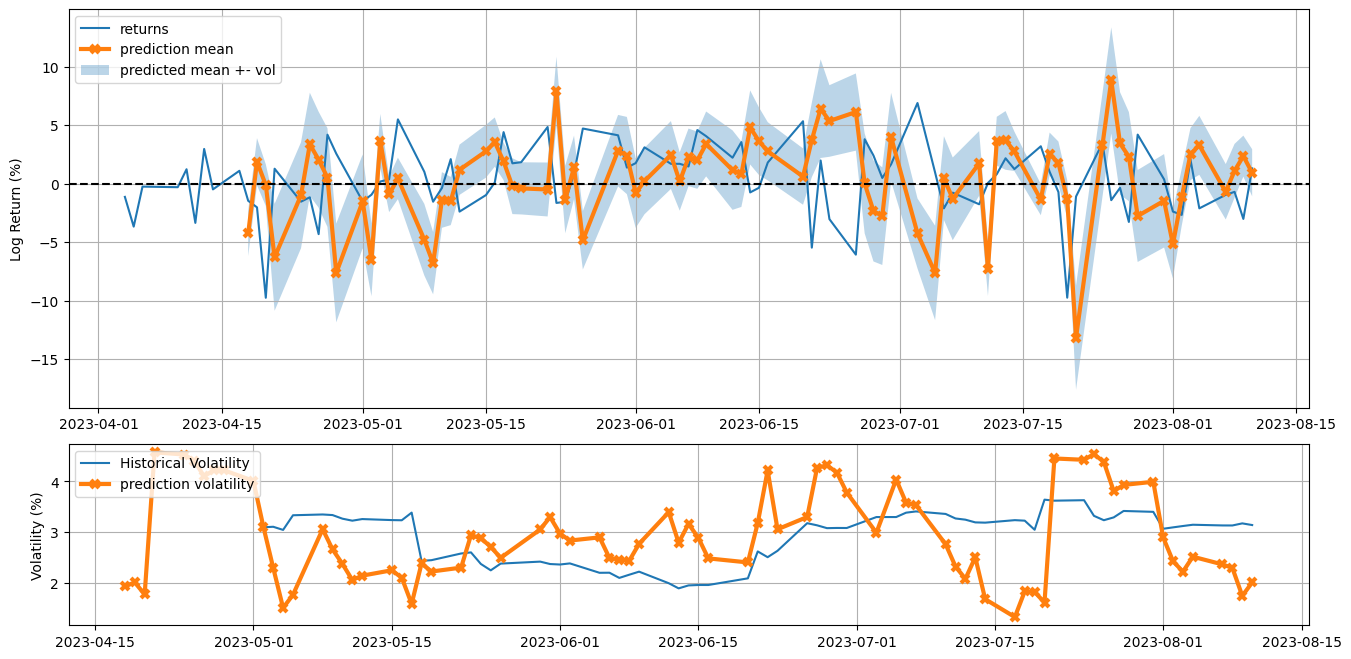

In [56]:
fig = plt.figure(figsize=(16,8))
spec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)

# Graph 1 - Return
ax = fig.add_subplot(spec[:2,0])
ax.plot(df_predict["Date"], 
        df_predict["Return"]*100, label="returns")

ax.plot(df_predict["Date"], 
        df_predict["Return_predict"]*100,label="prediction mean", marker="x", linewidth=3, markeredgewidth=3)
ax.axhline(0,color="black",linestyle="--")
ax.fill_between(
    df_predict["Date"], 
    df_predict["Return_predict_upper"]*100, 
    df_predict["Return_predict_lower"]*100, 
    alpha=0.3,label="predicted mean +- vol"
)
ax.legend(loc="upper left")
ax.set_ylabel("Log Return (%)")
ax.grid()

# Graph 2 - Volatility
ax = fig.add_subplot(spec[2,0])
ax.plot(df_predict["Date"], 
        df_predict["Return_Log_Std"]*100, label="Historical Volatility")
ax.plot(df_predict["Date"],
        df_predict["Volatility_predict"]*100,label="prediction volatility", marker="x", linewidth=3, markeredgewidth=3)

ax.legend(loc="upper left")
ax.set_ylabel("Volatility (%)")
ax.grid()
plt.show()